In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os
os.environ['TORCH_HOME'] = "/media/hdd/Datasets/"
import sys
sys.path.append("../")

In [2]:
from sprintdl.main import *
import sprintdl

In [3]:
device = torch.device('cuda',0)
from torch.nn import init
import torch
import math

In [50]:
from sprintdl.models.xresnet import *

In [51]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define required

In [53]:
fpath = Path("/media/hdd/Datasets/ArtClass/")

train_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=128, width=128),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
    ]
)

tfms = [ATransform(train_transform, c_in = 3)]
bs = 256

# Actual process

In [54]:
il = ImageList.from_files(fpath, tfms=tfms)

In [55]:
il

ImageList (36702 items)
[PosixPath('/media/hdd/Datasets/ArtClass/Unpopular/mimang.art/69030963_140928767119437_3621699865915593113_n.jpg'), PosixPath('/media/hdd/Datasets/ArtClass/Unpopular/mimang.art/72464485_484151519164558_7996390942427275987_n.jpg'), PosixPath('/media/hdd/Datasets/ArtClass/Unpopular/mimang.art/67061598_659075951237852_8193482831220395614_n.jpg'), PosixPath('/media/hdd/Datasets/ArtClass/Unpopular/mimang.art/52369429_387255328723206_9033916457772710578_n.jpg'), PosixPath('/media/hdd/Datasets/ArtClass/Unpopular/mimang.art/67249582_2358754971005882_1419227919627445111_n.jpg'), PosixPath('/media/hdd/Datasets/ArtClass/Unpopular/mimang.art/53117277_787218161655836_7400982805295717482_n.jpg'), PosixPath('/media/hdd/Datasets/ArtClass/Unpopular/mimang.art/66306740_2081645612139014_2862011611265245646_n.jpg'), PosixPath('/media/hdd/Datasets/ArtClass/Unpopular/mimang.art/51053509_419271458822091_6368645951995838212_n.jpg'), PosixPath('/media/hdd/Datasets/ArtClass/Unpopular/mim

In [56]:
tm= Path("/media/hdd/Datasets/ArtClass/Unpopular/mimang.art/69030963_140928767119437_3621699865915593113_n.jpg")

In [57]:
sd = SplitData.split_by_func(il, partial(random_splitter, p_valid = .2))
ll = label_by_func(sd, lambda x: str(x).split("/")[-3], proc_y=CategoryProcessor())

In [58]:
n_classes = len(set(ll.train.y.items))

In [59]:
data = ll.to_databunch(bs, c_in=3, c_out=2)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


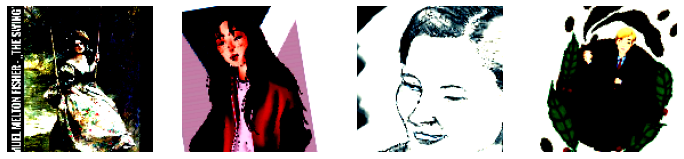

In [60]:
show_batch(data, 4)

# Training

In [61]:
lr = .001
pct_start = 0.5
phases = create_phases(pct_start)
sched_lr  = combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
sched_mom = combine_scheds(phases, cos_1cycle_anneal(0.95, 0.85, 0.95))

cbfs = [
    partial(AvgStatsCallback,accuracy),
    partial(ParamScheduler, 'lr', sched_lr),
    partial(ParamScheduler, 'mom', sched_mom),
        partial(BatchTransformXCallback, norm_imagenette),
    ProgressCallback,
    Recorder,
#     MixUp,
       partial(CudaCallback, device)]

loss_func=LabelSmoothingCrossEntropy()
opt_func = adam_opt(mom=0.9, mom_sqr=0.99, eps=1e-6, wd=1e-2)

In [63]:
arch = partial(xresnet34, c_out =n_classes)()

learn = Learner(arch, data, loss_func, lr=lr, cb_funcs=cbfs, opt_func=opt_func)

In [64]:
learn.fit(1)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.646614,0.647458,0.617232,0.677624,02:08
